In [43]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import plot_utils as p
import reward_functions as rfns

from quad_env import Env

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Concatenate, Lambda, BatchNormalization
from keras.layers import normalization as N
from keras.optimizers import Adam, SGD
#Keras rl
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
def target_fn(task):
    # Huge crash penalty
    if task.sim.pose[2] <= 0:
        return -100
    delta_target = task.target_pos - task.sim.pose[:3]
    #Any deviation from no rotations is bad
    ang_vel_penalty = -(abs(task.sim.angular_v)).sum()
    #Any radial error is bad
    radial_error_penalty = -(np.linalg.norm(delta_target[:2]))
    #Any effort at all going up is very good. 
    # * 1000 seems excessive, but when we're talking mm at launch we need some sort of big reward
    # z_reward = 1.0 / np.abs(delta_target[2])
    z_reward = 1.0 / delta_target[2] ** 2
    return (z_reward + ang_vel_penalty + radial_error_penalty) / 10.0
              
takeoff_task = Env(target_pos=np.array([0., 0., 10.]), reward_fn=target_fn)

In [45]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    e = np.exp(x)
    ne = np.exp(-e)
    return (e - ne) / (e + ne)
    
def ranged_sigmoid(lo, hi):
    lambda x: sigmoid(x) * (hi - lo) + lo
    
def ranged_tanh(lo, hi):
    lambda x: (tanh(x) + 1.0) * 0.5 * (hi - lo) + lo
    
def capped(lo, hi):
    lambda x: min(max(x, lo), hi)
    
def build_actor(nS, nA, action_min, action_max, print_summary=False):
    actor = Sequential()
    actor.add(Flatten(input_shape=(1,nS)))
    actor.add(Dense(512, activation='relu'))
    #Why BN no workey?
    #actor.add(N.BatchNormalization())
    #actor.add(BatchNormalization())
    actor.add(Dense(256, activation='relu'))
    #actor.add(BatchNormalization())
    actor.add(Dense(128, activation='relu'))
    #actor.add(BatchNormalization())
    #actor.add(Dense(nA, activation=ranged_sigmoid(action_min, action_max)))
    actor.add(Dense(nA, activation=capped(action_min, action_max)))
    #actor.add(Dense(nA, activation='linear'))
    if print_summary: 
        print(actor.summary())
    return actor

def build_critic(nS, nA, print_summary=False):
    action_input = Input(shape=(nA,), name='action_input')
    observation_input = Input(shape=(1,nS), name='observation_input')
    flattened_observation = Flatten()(observation_input)
    x = Concatenate()([action_input, flattened_observation])
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(1, activation='linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    if print_summary: 
        print(critic.summary())
    return action_input, critic

def build_agent(nS, nA, action_min, action_max):
    actor = build_actor(nS, nA, action_min, action_max)
    action_input, critic = build_critic(nS, nA)
    agent = DDPGAgent(nb_actions=nA, 
                      actor=actor, 
                      critic=critic, 
                      critic_action_input=action_input,
                      memory=SequentialMemory(limit=100000, window_length=1), 
#                       nb_steps_warmup_critic=100, 
#                       nb_steps_warmup_actor=100,
                      random_process=OrnsteinUhlenbeckProcess(size=nA, theta=20.55, sigma=10.3), 
                      gamma=0.99, 
                      target_model_update=0.0001)
    agent.compile(Adam(lr=0.0001, clipnorm=1.), metrics=['mae'])
#     agent.compile(SGD(lr=0.0001), metrics=['mae'])
    return agent

In [46]:
#Create an agent using the keras-rl API
takeoff_agent = build_agent(takeoff_task.state_size, 
                            takeoff_task.action_size, 
                            takeoff_task.action_low, 
                            takeoff_task.action_high)

In [47]:
training_history = takeoff_agent.fit(takeoff_task, 
                                     nb_steps=10000, 
                                     visualize=False, 
                                     verbose=1, 
                                     nb_max_episode_steps=200,
                                     action_repetition=1,
                                     nb_max_start_steps=3,
                                     start_step_policy=lambda x: [800, 800, 800, 800])

Training for 10000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 109s 11ms/step - reward: -14.1791
done, took 108.946 seconds


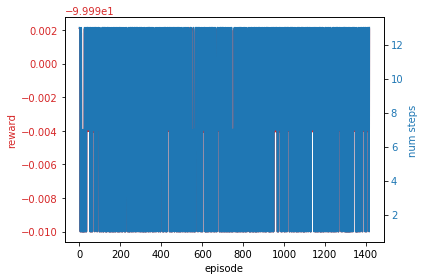

In [48]:
p.plot_episode_data(training_history)

In [49]:
def eval_episode(task, agent):
    labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
              'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
              'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4', 'reward']
    results = {x : [] for x in labels}

    state = task.reset() # start a new episode
    while True:
        rotor_speeds = agent.forward(state) 
        next_state, reward, done, _ = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + \
            list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds) + [reward]
        for ii in range(len(labels)): 
            results[labels[ii]].append(to_write[ii])
        state = next_state
        if done:
            break
    return results

In [53]:
takeoff_results = eval_episode(takeoff_task, takeoff_agent)

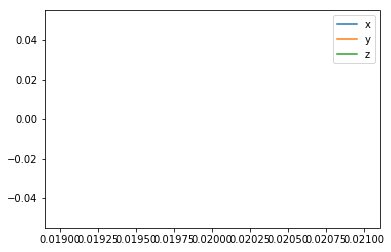

In [54]:
p.plot_pos(takeoff_results)

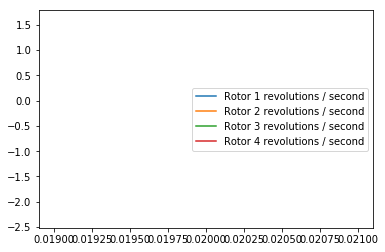

In [55]:
p.plot_actions(takeoff_results)